In [3]:
import numpy as np
import pandas as pd
import sys, os
import csv
sys.path.append('/scicore/home/nimwegen/degroo0000/Bonsai-data-representation')
from scipy.spatial import distance
import matplotlib.pyplot as plt
from paper_figure_scripts_and_notebooks.simulating_datasets.analyzing_simulated_datasets.knn_recall_helpers import get_pdists_on_tree, Dataset, compare_pdists_to_truth_per_cell
from scipy.spatial.distance import squareform
import logging
logging.getLogger("umap").disabled = True
log_level = logging.ERROR
FORMAT = '%(asctime)s %(name)s %(funcName)s %(message)s'
logging.basicConfig(format=FORMAT, datefmt='%H:%M:%S',
                    level=log_level)
plt.set_loglevel(level='warning')

/scicore/home/nimwegen/degroo0000/miniconda3/envs/bonsai_analysis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
"""--------------------Layout settings----------------------"""
SMALL_SIZE = 9
MEDIUM_SIZE = 11
BIGGER_SIZE = 13

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Get list of datasets and prepare dictionaries to hold data

In [6]:
base_folder = '/scicore/home/nimwegen/degroo0000/bonsai-development/slurm_runs_pipeline/output/no_noise_simulated'
poss_datasets = os.listdir(base_folder)
all_datasets = []
for dataset in poss_datasets:
    if os.path.exists(os.path.join(base_folder,dataset,'bonsai')):
        bonsai_folders = os.listdir(os.path.join(base_folder,dataset,'bonsai'))
        if any(s.startswith("final_bonsai") for s in bonsai_folders):
            all_datasets.append(dataset)
n_datasets = len(all_datasets)
print("We've got {} datasets.".format(n_datasets))

We've got 64 datasets.


In [7]:
sorted(all_datasets)

['no_noise_nGene10000_nCell100',
 'no_noise_nGene10000_nCell1000',
 'no_noise_nGene10000_nCell1000_orderedgenes',
 'no_noise_nGene10000_nCell1000_sampledposterior',
 'no_noise_nGene10000_nCell1000_zscoregenes',
 'no_noise_nGene10000_nCell1000_zscoregenesnosampling',
 'no_noise_nGene10000_nCell7509',
 'no_noise_nGene1000_nCell100',
 'no_noise_nGene1000_nCell1000',
 'no_noise_nGene1000_nCell1000_orderedgenes',
 'no_noise_nGene1000_nCell1000_sampledposterior',
 'no_noise_nGene1000_nCell1000_zscoregenes',
 'no_noise_nGene1000_nCell1000_zscoregenesnosampling',
 'no_noise_nGene1000_nCell7509',
 'no_noise_nGene100_nCell100',
 'no_noise_nGene100_nCell1000',
 'no_noise_nGene100_nCell1000_orderedgenes',
 'no_noise_nGene100_nCell1000_sampledposterior',
 'no_noise_nGene100_nCell1000_zscorecutoff',
 'no_noise_nGene100_nCell1000_zscoregenes',
 'no_noise_nGene100_nCell1000_zscoregenesnosampling',
 'no_noise_nGene100_nCell7509',
 'no_noise_nGene10_nCell100',
 'no_noise_nGene10_nCell1000',
 'no_noise_n

In [8]:
type_suffix = 'orderedgenes'
type_suffix = 'zscoregenes'
type_suffix = 'zscorecutoff'
type_suffix = 'zscoregenesnosampling'

In [9]:
gene_numbers = [10, 100, 1000, 10000]
cell_numbers = [1000]

In [10]:
datasets = []
for ind_dataset, dataset in enumerate(all_datasets):
    split_dataset = dataset.split('_')
    if split_dataset[-1] != type_suffix:
        continue
    else:
        nCell = split_dataset[-2]
        nGene = split_dataset[-3]
    n_cell = int(nCell[5:])
    n_gene = int(nGene[5:])
    if (n_cell not in cell_numbers) or (n_gene not in gene_numbers):
        continue
    print(nCell, nGene)
    datasets.append(dataset)
n_datasets = len(datasets)
print("We've got {} datasets.".format(n_datasets))

nCell1000 nGene1000
nCell1000 nGene100
nCell1000 nGene10000
nCell1000 nGene10
We've got 4 datasets.


In [11]:
if n_datasets > 10:
    tab20 = plt.get_cmap("tab20")
else:
    tab20 = plt.get_cmap("tab10")
colors = [tab20(i) for i in range(n_datasets)]

In [12]:
info_dss = {}
for ind_dataset, dataset in enumerate(datasets):
    split_dataset = dataset.split('_')
    if split_dataset[-1] != type_suffix:
        continue
    else:
        nCell = split_dataset[-2]
        nGene = split_dataset[-3]
    print(nCell, nGene)
    n_cell = int(nCell[5:])
    n_gene = int(nGene[5:])
    if (n_cell not in cell_numbers) or (n_gene not in gene_numbers):
        continue
    dataset_dict = {'n_cell': n_cell, 'n_gene': n_gene, 
                    'plt_coords': (gene_numbers.index(n_gene), cell_numbers.index(n_cell)), 
                    'color': colors[ind_dataset], 'index': ind_dataset, 'dataset_path': os.path.join(base_folder,dataset)}
    info_dss[dataset] = dataset_dict

nCell1000 nGene1000
nCell1000 nGene100
nCell1000 nGene10000
nCell1000 nGene10


In [14]:
pdists_true_dss = {dataset: None for dataset in datasets}
pdists_inferred_dss = {dataset: None for dataset in datasets}

### Create function to get a many-time use fig, ax combination

In [15]:
def get_fig_ax(xlabel=None, ylabel=None, title=None, sharex=None, sharey=None):
    # ncols = np.minimum(int(np.ceil(np.sqrt(n_datasets))),4)
    # nrows = int(np.ceil(n_datasets/ncols))
    # fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
    fig, axs = plt.subplots(ncols=len(cell_numbers), nrows=len(gene_numbers), 
                            figsize=(len(cell_numbers)*4, len(gene_numbers)*3), 
                            sharex=sharex, sharey=sharey)
    axs_flat = axs.flatten()
    for ax in axs.flat:
        ax.tick_params(axis='x', which='both', labelbottom=True)
        ax.tick_params(axis='y', which='both', labelleft=True)
    
    for ind_ds, dataset in enumerate(datasets):
        info = info_dss[dataset]
        ax_row, ax_col = info['plt_coords']
        if len(cell_numbers) == 1:
            ax = axs[ax_row]
        else:
            ax = axs[ax_row, ax_col]
        ax.set_title('|C| = {}, |G| = {}'.format(info['n_cell'], info['n_gene']))

    for ax_row in range(len(gene_numbers)):
        for ax_col in range(len(cell_numbers)):
            if len(cell_numbers) == 1:
                ax = axs[ax_row]
            else:
                ax = axs[ax_row, ax_col]
            if (xlabel is not None) and (ax_row == (len(gene_numbers)-1)):
                ax.set_xlabel(xlabel)
            if (ylabel is not None)  and (ax_col == 0):
                ax.set_ylabel(ylabel)
    if title is not None:
        fig.suptitle(title)
    
    return fig, axs

### First get pairwise distances of ground truth data

In [16]:
for dataset in datasets:
    sanity_folder = os.path.join(base_folder, dataset, 'Sanity')
    true_deltas = pd.read_csv(os.path.join(sanity_folder, 'delta_vmax.txt'), sep='\t', header=None).values.astype(dtype=float)
    num_dims = true_deltas.shape[0]
    true_dists = distance.pdist(true_deltas.T, metric='sqeuclidean') / num_dims
    pdists_true_dss[dataset] = true_dists

no_noise_nGene1000_nCell1000_zscoregenesnosampling
no_noise_nGene100_nCell1000_zscoregenesnosampling
no_noise_nGene10000_nCell1000_zscoregenesnosampling
no_noise_nGene10_nCell1000_zscoregenesnosampling


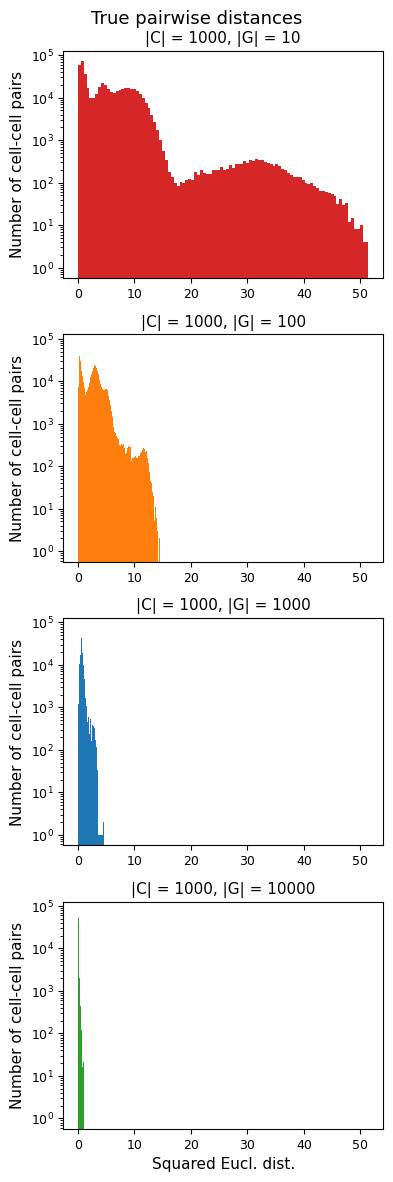

In [17]:
fig, axs = get_fig_ax(xlabel='Squared Eucl. dist.', ylabel='Number of cell-cell pairs', title='True pairwise distances', sharex=True, sharey='col')

# Visualize the true distances
for ind_ds, dataset in enumerate(datasets):
    info = info_dss[dataset]
    ax_row, ax_col = info['plt_coords']
    print(dataset)
    if len(cell_numbers) == 1:
        ax = axs[ax_row]
    else:
        ax = axs[ax_row, ax_col]
    ax.hist(pdists_true_dss[dataset], bins=100, color=info['color'], log=True)
plt.tight_layout()

### Then get inferred pairwise distances by getting summed branch lengths

In [19]:
# I first need the cell IDs, and paths to the newick files
cell_ids_dss = {}
for dataset in datasets:
    info = info_dss[dataset]
    cell_id_path = os.path.join(info['dataset_path'], 'Sanity', 'cellID.txt')
    cell_ids = []
    with open(cell_id_path, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            cell_ids.append(row[0])
    cell_ids_dss[dataset] = cell_ids

    for bonsai_folder in os.listdir(os.path.join(info['dataset_path'],'bonsai')):
        if bonsai_folder.startswith('final_bonsai'):
            info['bonsai_path'] = os.path.join(info['dataset_path'],'bonsai', bonsai_folder)

In [20]:
bonsai_dists_dss = {}
for ind_dataset, dataset in enumerate(datasets):
    info = info_dss[dataset]
    print(dataset)
    nwk_path = os.path.join(info['bonsai_path'], 'tree.nwk')
    bonsai_dists = get_pdists_on_tree(nwk_path, cell_ids_dss[dataset])
    bonsai_dists_dss[dataset] = bonsai_dists

no_noise_nGene1000_nCell1000_zscoregenesnosampling
no_noise_nGene100_nCell1000_zscoregenesnosampling
no_noise_nGene10000_nCell1000_zscoregenesnosampling
no_noise_nGene10_nCell1000_zscoregenesnosampling


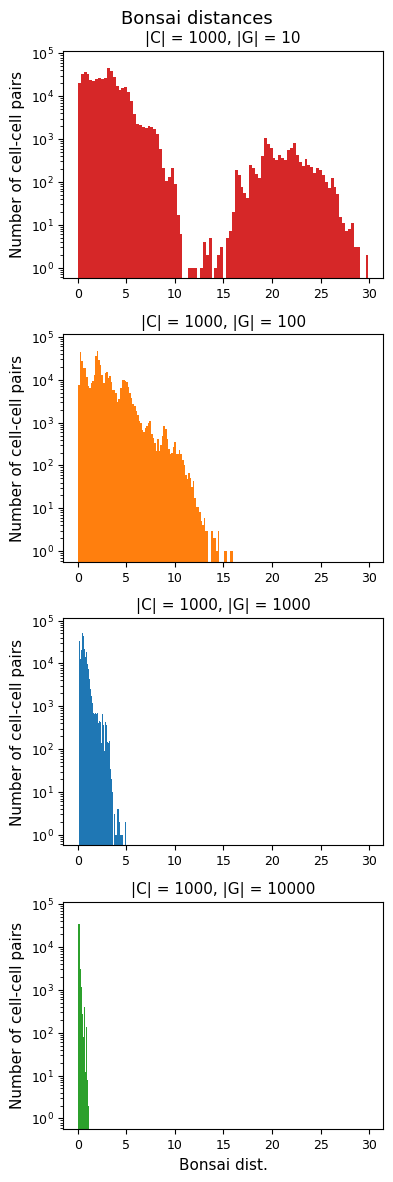

In [21]:
fig, axs = get_fig_ax(xlabel='Bonsai dist.', ylabel='Number of cell-cell pairs', title='Bonsai distances', sharex=True, sharey='col')

# Visualize the true distances
for ind_ds, dataset in enumerate(datasets):
    info = info_dss[dataset]
    if len(cell_numbers) == 1:
        ax = axs[ax_row]
    else:
        ax = axs[ax_row, ax_col]
    ax_row, ax_col = info['plt_coords']
    if len(cell_numbers) == 1:
        ax = axs[ax_row]
    else:
        ax = axs[ax_row, ax_col]
    ax.hist(bonsai_dists_dss[dataset], bins=100, color=info['color'], log=True)
plt.tight_layout()

### Create comparison plot, true vs pairwise distance

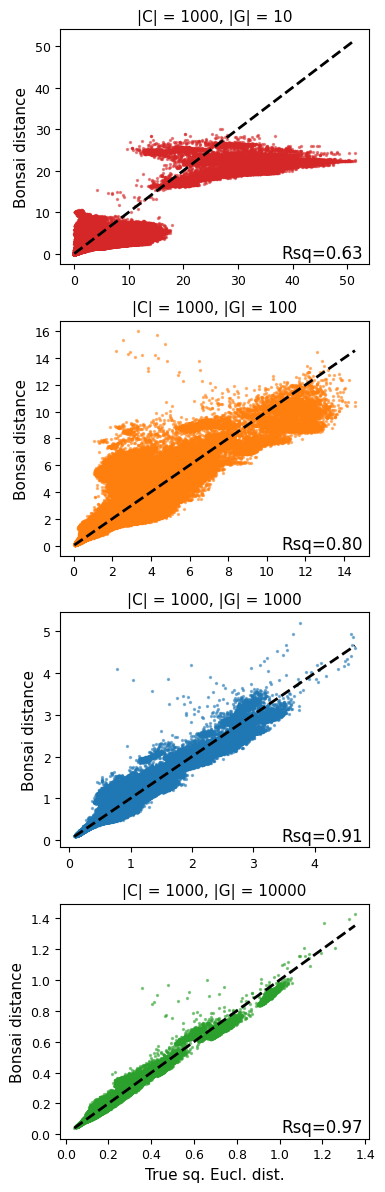

In [22]:
fig, axs = get_fig_ax(xlabel='True sq. Eucl. dist.', ylabel='Bonsai distance', title=None)

loglog_corr = False

# Visualize the true distances
for ind_ds, dataset in enumerate(datasets):
    info = info_dss[dataset]
    ax_row, ax_col = info['plt_coords']
    if len(cell_numbers) == 1:
        ax = axs[ax_row]
    else:
        ax = axs[ax_row, ax_col]
    true_dists = pdists_true_dss[dataset]
    bonsai_dists = bonsai_dists_dss[dataset]
    ax.scatter(true_dists, bonsai_dists, s=2, alpha=0.5, color=info['color'])

    if loglog_corr:
        ax.set_xscale('log')
        ax.set_yscale('log')
        
    nonzeros_true = true_dists != 0
    nonzeros_data = bonsai_dists != 0
    nonzeros_all = nonzeros_data * nonzeros_true

    # Add correlation line
    if loglog_corr:
        log_truedists = true_dists.copy()
        log_truedists[nonzeros_true] = np.log(true_dists[nonzeros_true])
    else:
        log_truedists = true_dists

    if loglog_corr:
        log_truedists_nonzeros_cell = log_truedists[nonzeros_all]
        log_datadists_cell = np.log(bonsai_dists[nonzeros_all])
    else:
        log_truedists_nonzeros_cell = log_truedists
        log_datadists_cell = bonsai_dists

    Clog = np.cov(np.vstack((log_truedists_nonzeros_cell - np.mean(log_truedists_nonzeros_cell),
                             log_datadists_cell - np.mean(log_datadists_cell))))
    pearsonR = Clog[0, 1] / np.sqrt(Clog[0, 0] * Clog[1, 1])

    eigVals, eigVecs = np.linalg.eig(Clog)
    max_eigval = np.argmax(eigVals)
    slopepca1log = eigVecs[1, max_eigval] / eigVecs[0, max_eigval]
    regLineXlog = np.linspace(log_truedists_nonzeros_cell.min(), log_truedists_nonzeros_cell.max(), 20)
    regLineYlog = slopepca1log * (
            regLineXlog - log_truedists_nonzeros_cell.mean()) + log_datadists_cell.mean()

    if loglog_corr:
        # ax.plot(np.exp(regLineXlog), np.exp(regLineYlog), '--', lw=2, c='black', zorder=10)
        ax.plot(np.exp(regLineXlog), np.exp(regLineXlog), '--', lw=2, c='black', zorder=10)
    else:
        # ax.plot(regLineXlog, regLineYlog, '--', lw=2, c='black', zorder=10)
        ax.plot(regLineXlog, regLineXlog, '--', lw=2, c='black', zorder=10)
    corr_measure = 'Rsq'
    # corr_measure = '-log(1-R^2)'
    if corr_measure == 'Rsq':
        corr_label = pearsonR ** 2
    elif corr_measure == '-log(1-R^2)':
        corr_label = -np.log(1-pearsonR ** 2)
    # ax.text(0.98, 0.01,
    #              "Slope: {:.2f},\n{}={:.2f}".format(slopepca1log, corr_measure, corr_label),
    #              horizontalalignment='right', verticalalignment='bottom',
    #              transform=ax.transAxes, fontsize=12)
    ax.text(0.98, 0.01,
             "{}={:.2f}".format(corr_measure, corr_label),
             horizontalalignment='right', verticalalignment='bottom',
             transform=ax.transAxes, fontsize=12)


plt.tight_layout()



Treating dataset no_noise_nGene1000_nCell1000_zscoregenesnosampling

Finished loading dataset of type delta_true
Finished loading dataset of type bonsai
Comparing pairwise distances of dataset: 'bonsai'.


Treating dataset no_noise_nGene100_nCell1000_zscoregenesnosampling

Finished loading dataset of type delta_true
Finished loading dataset of type bonsai
Comparing pairwise distances of dataset: 'bonsai'.


Treating dataset no_noise_nGene10000_nCell1000_zscoregenesnosampling

Finished loading dataset of type delta_true
Finished loading dataset of type bonsai
Comparing pairwise distances of dataset: 'bonsai'.


Treating dataset no_noise_nGene10_nCell1000_zscoregenesnosampling

Finished loading dataset of type delta_true
Finished loading dataset of type bonsai
Comparing pairwise distances of dataset: 'bonsai'.


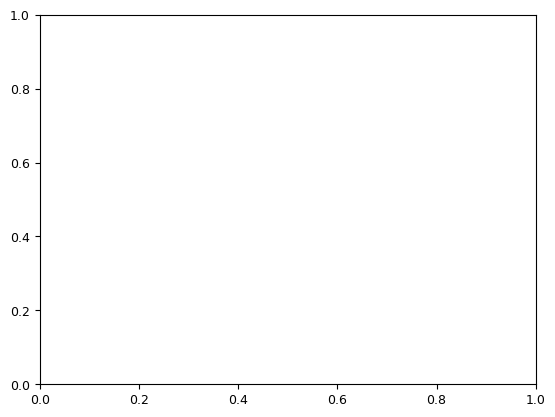

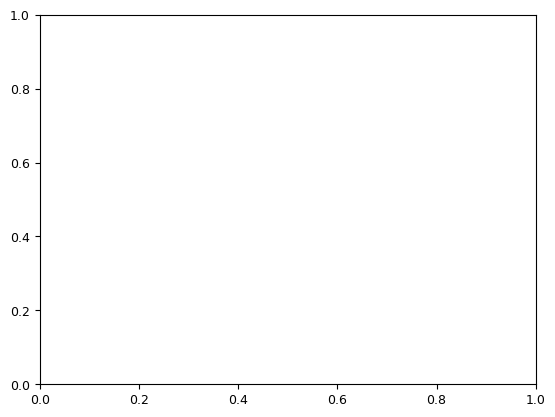

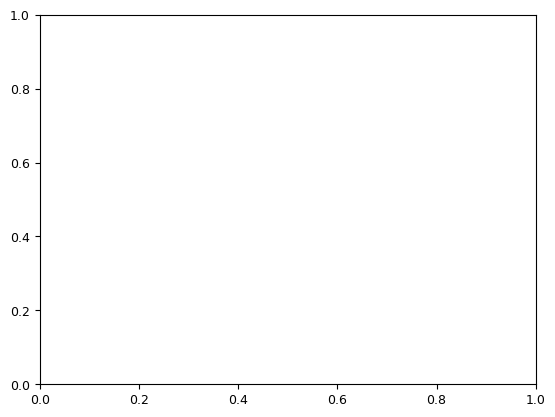

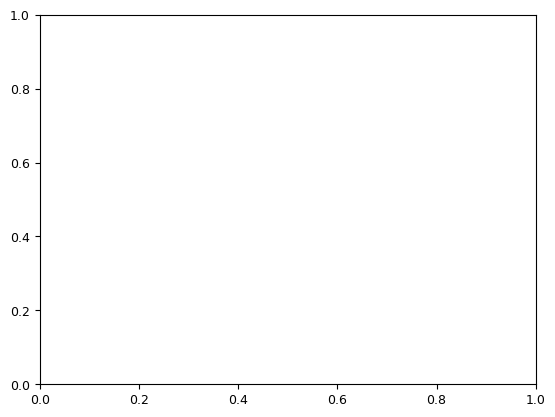

In [23]:
bonsai_objcts_dss = {}
for dataset in datasets:
    print("\n\nTreating dataset {}\n".format(dataset))
    info = info_dss[dataset]
    ax_row, ax_col = info['plt_coords']
    if len(cell_numbers) == 1:
        ax = axs[ax_row]
    else:
        ax = axs[ax_row, ax_col]
    true_dists = pdists_true_dss[dataset]
    bonsai_dists = bonsai_dists_dss[dataset]

    true_objct = Dataset(distances=true_dists, data_type='delta_true', data_id='delta_true')
    data_id = dataset
    bonsai_objct = Dataset(distances=bonsai_dists, data_type='bonsai', data_id=data_id)
    fig_fake, ax_fake = plt.subplots()
    avg_rel_diffs, R_vals = compare_pdists_to_truth_per_cell([true_objct, bonsai_objct], 
                                                             make_fig=True, axs=ax, 
                                                             set_lims=False, return_Rvals=True, 
                                                             loglog_corr=False)
    bonsai_objcts_dss[dataset] = bonsai_objct

In [ ]:
fig, axs = get_fig_ax(xlabel='Per-cell correlations (Pearson R^2)', ylabel='Number of cells', title='Per-cell correlations between true and inferred distances', sharex=True, sharey='col')

for ind_ds, dataset in enumerate(datasets):
    info = info_dss[dataset]
    ax_row, ax_col = info['plt_coords']
    if len(cell_numbers) == 1:
        ax = axs[ax_row]
    else:
        ax = axs[ax_row, ax_col]
    bonsai_objct = bonsai_objcts_dss[dataset]
    pearsonRs = bonsai_objct.pearsonRs
    ax.hist(pearsonRs ** 2, bins=100, density=True, color=info['color'], log=False)
plt.tight_layout()

## Get one figure where total correlation and per-cell correlation are put together

In [ ]:
ncols = 2
fig, axs = plt.subplots(ncols=ncols, nrows=len(gene_numbers), 
                        figsize=(ncols*4, len(gene_numbers)*3))
for i in range(1, len(gene_numbers)):  # columns 1 to 3
    axs[i, 1].sharey(axs[0, 1])
    axs[i, 1].sharex(axs[0, 1])
axs_flat = axs.flatten()
for ax in axs.flat:
    ax.tick_params(axis='x', which='both', labelbottom=True)
    ax.tick_params(axis='y', which='both', labelleft=True)

for ind_ds, dataset in enumerate(datasets):
    info = info_dss[dataset]
    ax_row, ax_col = info['plt_coords']
    ax = axs[ax_row, 0]
    ax.set_title('|C| = {}, |G| = {}'.format(info['n_cell'], info['n_gene']))
    ax = axs[ax_row, 1]
    ax.set_title('|C| = {}, |G| = {}'.format(info['n_cell'], info['n_gene']))

xlabels = ['True sq. Eucl. distance', 'Per-cell correlations (Pearson R^2)']
ylabels = ['Bonsai summed branch lengths', 'Number of cells']
for ax_row in range(len(gene_numbers)):
    for ax_col in range(2):
        ax = axs[ax_row, ax_col]
        if (xlabels is not None) and (ax_row == (len(gene_numbers)-1)):
            ax.set_xlabel(xlabels[ax_col])
        if (ylabels is not None):
            ax.set_ylabel(ylabels[ax_col])

loglog_corr = False

# Visualize the true distances
for ind_ds, dataset in enumerate(datasets):
    info = info_dss[dataset]
    ax_row, ax_col = info['plt_coords']
    ax = axs[ax_row, ax_col]
    true_dists = pdists_true_dss[dataset]
    bonsai_dists = bonsai_dists_dss[dataset]
    ax.scatter(true_dists, bonsai_dists, s=2, alpha=0.5, color=info['color'])

    if loglog_corr:
        ax.set_xscale('log')
        ax.set_yscale('log')
        
    nonzeros_true = true_dists != 0
    nonzeros_data = bonsai_dists != 0
    nonzeros_all = nonzeros_data * nonzeros_true

    # Add correlation line
    if loglog_corr:
        log_truedists = true_dists.copy()
        log_truedists[nonzeros_true] = np.log(true_dists[nonzeros_true])
    else:
        log_truedists = true_dists

    if loglog_corr:
        log_truedists_nonzeros_cell = log_truedists[nonzeros_all]
        log_datadists_cell = np.log(bonsai_dists[nonzeros_all])
    else:
        log_truedists_nonzeros_cell = log_truedists
        log_datadists_cell = bonsai_dists

    Clog = np.cov(np.vstack((log_truedists_nonzeros_cell - np.mean(log_truedists_nonzeros_cell),
                             log_datadists_cell - np.mean(log_datadists_cell))))
    pearsonR = Clog[0, 1] / np.sqrt(Clog[0, 0] * Clog[1, 1])

    eigVals, eigVecs = np.linalg.eig(Clog)
    max_eigval = np.argmax(eigVals)
    slopepca1log = eigVecs[1, max_eigval] / eigVecs[0, max_eigval]
    regLineXlog = np.linspace(log_truedists_nonzeros_cell.min(), log_truedists_nonzeros_cell.max(), 20)
    regLineYlog = slopepca1log * (
            regLineXlog - log_truedists_nonzeros_cell.mean()) + log_datadists_cell.mean()

    if loglog_corr:
        # ax.plot(np.exp(regLineXlog), np.exp(regLineYlog), '--', lw=2, c='black', zorder=10)
        ax.plot(np.exp(regLineXlog), np.exp(regLineXlog), '--', lw=2, c='black', zorder=10)
    else:
        # ax.plot(regLineXlog, regLineYlog, '--', lw=2, c='black', zorder=10)
        ax.plot(regLineXlog, regLineXlog, '--', lw=2, c='black', zorder=10)
    corr_measure = 'Rsq'
    # corr_measure = '-log(1-R^2)'
    if corr_measure == 'Rsq':
        corr_label = pearsonR ** 2
    elif corr_measure == '-log(1-R^2)':
        corr_label = -np.log(1-pearsonR ** 2)
    # ax.text(0.98, 0.01,
    #              "Slope: {:.2f},\n{}={:.2f}".format(slopepca1log, corr_measure, corr_label),
    #              horizontalalignment='right', verticalalignment='bottom',
    #              transform=ax.transAxes, fontsize=12)
    ax.text(0.98, 0.01,
             "{}={:.2f}".format(corr_measure, corr_label),
             horizontalalignment='right', verticalalignment='bottom',
             transform=ax.transAxes, fontsize=12)


for ind_ds, dataset in enumerate(datasets):
    info = info_dss[dataset]
    ax_row, _ = info['plt_coords']
    ax = axs[ax_row, 1]
    bonsai_objct = bonsai_objcts_dss[dataset]
    pearsonRs = bonsai_objct.pearsonRs
    ax.hist(pearsonRs ** 2, bins=100, density=False, color=info['color'], log=False)

plt.tight_layout()

In [ ]:
fig.savefig(os.path.join(os.getcwd(), 'nonoise_dataset_accuracy_of_distance_estimates.png'), dpi=300)
fig.savefig(os.path.join(os.getcwd(), 'nonoise_dataset_accuracy_of_distance_estimates.svg'))

In [ ]:
print("Stored figures at: {}".format(os.path.join(os.getcwd(), 'nonoise_dataset_accuracy_of_distance_estimates.png')))

## Discarded

In [ ]:
# fig, axs = get_fig_ax(xlabel='Per-cell correlations (Pearson R^2)', ylabel='Number of cells', title='Per-cell correlations between true and inferred distances', sharex=True, sharey='col')
row0_pearsonRs = [None] * int(len(datasets)/len(cell_numbers))
row1_pearsonRs = [None] * int(len(datasets)/len(cell_numbers))
num_genes = [None] * int(len(datasets)/len(cell_numbers))

corr_measure = '-log(1-R^2)'

for ind_ds, dataset in enumerate(datasets):
    info = info_dss[dataset]
    ax_row, ax_col = info['plt_coords']
    bonsai_objct = bonsai_objcts_dss[dataset]
    pearsonRs = bonsai_objct.pearsonRs
    if ax_col == 0:
        if corr_measure == '-log(1-R^2)':
            row0_pearsonRs[ax_row] = -np.log(1-pearsonRs**2)
        num_genes[ax_row] = info['n_gene']
    if ax_col == 1:
        if corr_measure == '-log(1-R^2)':
            row1_pearsonRs[ax_row] = -np.log(1-pearsonRs**2)

# Create boxplots in separate figure as well, now grouped by dataset
boxprops = dict(linewidth=0.05)
flierprops = dict(markersize=2, markeredgewidth=0.5)
medianprops = dict(color='black', linewidth=1)
fig_bp, axs_bp = plt.subplots(figsize=(8,8), nrows=2, ncols=1);

for ind_pearsonRs, pearsonRs in enumerate([row0_pearsonRs, row1_pearsonRs]):
    dataset_descr = "Number of cells: {}".format(cell_numbers[0])
    tool_names = num_genes
    ax = axs_bp[ind_pearsonRs,]
    bplot = ax.boxplot(pearsonRs, whis=(5, 95), labels=tool_names, patch_artist=True, 
                           flierprops=flierprops, medianprops=medianprops, boxprops=boxprops)
    # fill with colors
    # for ind_patch, patch in enumerate(bplot['boxes']):
    #     patch.set_facecolor(color=tool_objcts_lst[ind_dataset][ind_patch].data_type_color)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    # ax.set_ylim(-0.05,1.05)
    ax.set_title(dataset_descr)
    ax.set_ylabel(corr_measure)
plt.tight_layout()


In [ ]:
# fig, axs = get_fig_ax(xlabel='Per-cell correlations (Pearson R^2)', ylabel='Number of cells', title='Per-cell correlations between true and inferred distances', sharex=True, sharey='col')
row0_pearsonRs = [None] * int(len(datasets)/2)
row1_pearsonRs = [None] * int(len(datasets)/2)
num_genes = [None] * int(len(datasets)/2)

corr_measure = 'R-squared'

for ind_ds, dataset in enumerate(datasets):
    info = info_dss[dataset]
    ax_row, ax_col = info['plt_coords']
    bonsai_objct = bonsai_objcts_dss[dataset]
    pearsonRs = bonsai_objct.pearsonRs
    if ax_col == 0:
        if corr_measure == '-log(1-R^2)':
            row0_pearsonRs[ax_row] = -np.log(1-pearsonRs**2)
        elif corr_measure == 'R-squared':
            row0_pearsonRs[ax_row] = pearsonRs**2
        num_genes[ax_row] = info['n_gene']
    if ax_col == 1:
        if corr_measure == '-log(1-R^2)':
            row1_pearsonRs[ax_row] = -np.log(1-pearsonRs**2)
        elif corr_measure == 'R-squared':
            row1_pearsonRs[ax_row] = pearsonRs**2

# Create boxplots in separate figure as well, now grouped by dataset
boxprops = dict(linewidth=0.05)
flierprops = dict(markersize=2, markeredgewidth=0.5)
medianprops = dict(color='black', linewidth=1)
fig_bp, axs_bp = plt.subplots(figsize=(8,8), nrows=2, ncols=1);

for ind_pearsonRs, pearsonRs in enumerate([row0_pearsonRs, row1_pearsonRs]):
    dataset_descr = "Number of cells: {}".format(cell_numbers[0])
    tool_names = num_genes
    ax = axs_bp[ind_pearsonRs,]
    bplot = ax.boxplot(pearsonRs, whis=(5, 95), labels=tool_names, patch_artist=True, 
                           flierprops=flierprops, medianprops=medianprops, boxprops=boxprops)
    # fill with colors
    # for ind_patch, patch in enumerate(bplot['boxes']):
    #     patch.set_facecolor(color=tool_objcts_lst[ind_dataset][ind_patch].data_type_color)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    # ax.set_ylim(-0.05,1.05)
    ax.set_title(dataset_descr)
    ax.set_ylabel(corr_measure)
plt.tight_layout()
